In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from data_utils import load_data, gaussian_filter_spatial

data_dict = load_data()

data_dict['time']

Reading Dicom directory: data/DigitalPhantomCT


array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
       52., 54., 56., 58.])

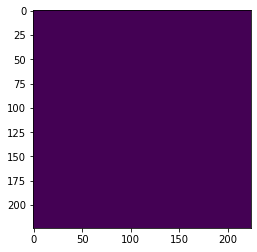

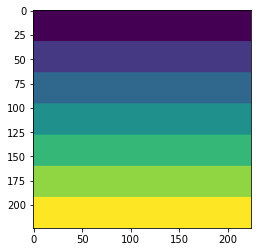

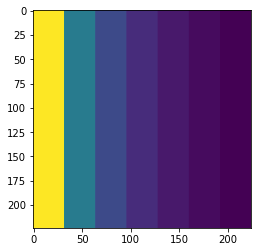

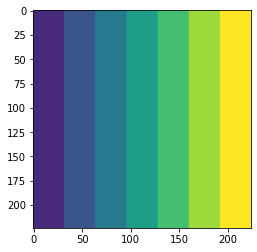

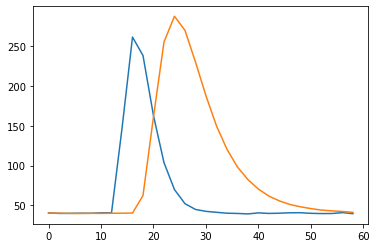

In [3]:
def show_data(data_dict):
    plt.imshow(data_dict['perfusion_values'][0,:,:,0], vmin=1, vmax=5)
    plt.show()
    plt.imshow(data_dict['perfusion_values'][0,:,:,1], vmin=0, vmax=3.)
    plt.show()
    plt.imshow(data_dict['perfusion_values'][0,:,:,2], vmin=3.4/60, vmax=24.0/60)
    plt.show()
    plt.imshow(data_dict['perfusion_values'][4,:,:,3], vmin=2.5, vmax=87.5)
    plt.show()

    plt.plot(data_dict['time'],data_dict['aif'])
    plt.plot(data_dict['time'], data_dict['vof'])
    # curves = np.array_split(data_dict['box_curves'][0,:32,], 7, axis=2)
    # plt.plot(np.mean(data_dict['box_curves'][0,:32,]))
    plt.show()
show_data(data_dict)

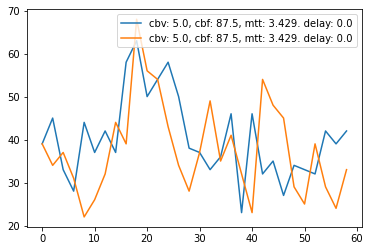

In [8]:
def plot_curves(data, cbv, i_delay, i_mtt):
    data = data_dict['box_curves']
    gt = data_dict['perfusion_values']
    i_delay = [i_delay] if not type(i_delay) == list else i_delay
    i_mtt = [i_mtt] if not type(i_mtt) == list else i_mtt
    assert(isinstance(i_delay, list) & isinstance(i_mtt, list) & isinstance(cbv, int))
    for i, j in zip(i_delay, i_mtt):
        plt.plot(data_dict['time'], data[cbv, :, i, j], label='cbv: {}, cbf: {}, mtt: {}. delay: {}'.format(
            np.round(gt[cbv,i,j,0],3),
            np.round(gt[cbv,i,j,3],3),
            np.round(gt[cbv,i,j,2]*60,3),
            np.round(gt[cbv,i,j,1],3))
            )
    plt.legend()
    plt.show()

plot_curves(data_dict, cbv=4, i_delay=[0, 0], i_mtt=[200, 201])
# cbv = 0
# i, j = 100, 100
# data_dict['box_curves'].shape

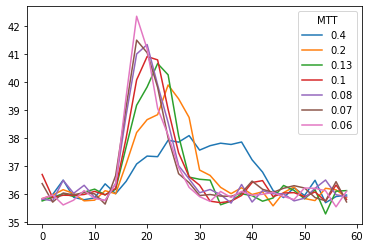

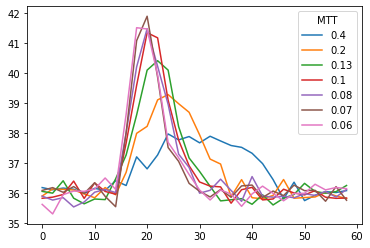

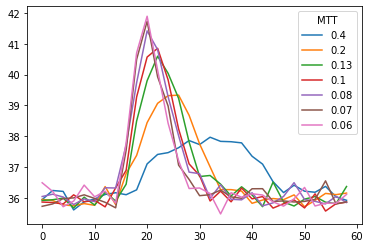

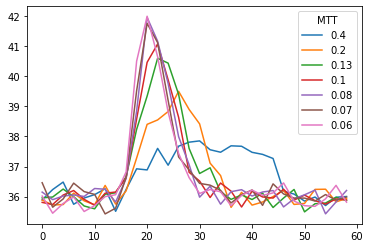

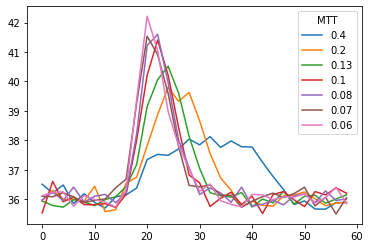

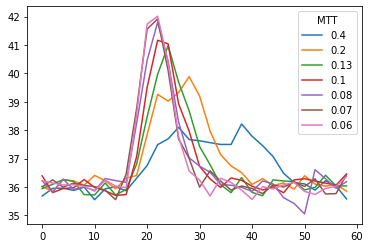

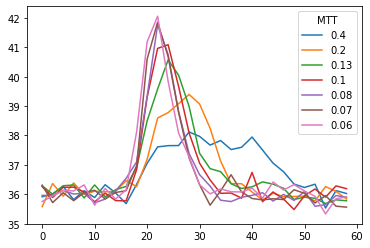

In [9]:
def plot_curve_mtts(data_dict, delay=0):
    data =  data_dict['box_curves']
    mtt_s = [24.0, 12.0, 8.0, 6.0, 4.8, 4.0, 3.4] # in seconds
    mtt_m = [t/60 for t in mtt_s]
    # split on delay time
    curves = np.array_split(data[0], 7, axis=1)
    # select curves with delay = 0 and split on MTT
    subcurves = np.array_split(curves[delay], 7, axis=2)
    # plot mean of each curves tile
    for ix, subcurve in enumerate(subcurves):
        plt.plot(data_dict['time'], np.mean(subcurve, axis=(1,2)), label=np.round(mtt_m[ix], 2))
    plt.legend(title='MTT')
    plt.show()
for i in range(0,7):

    plot_curve_mtts(data_dict, i)

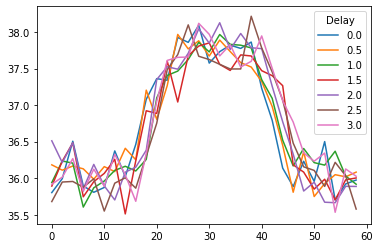

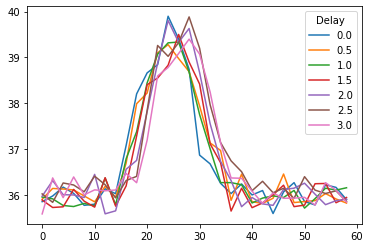

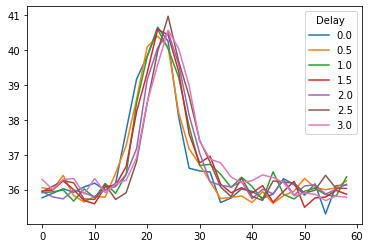

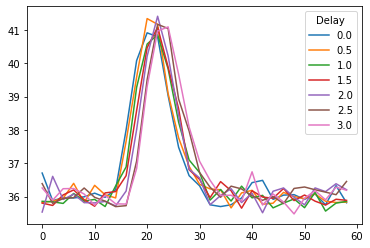

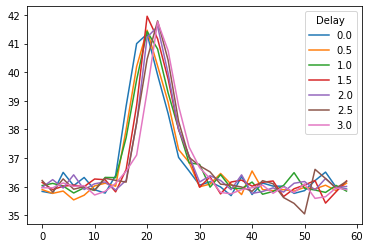

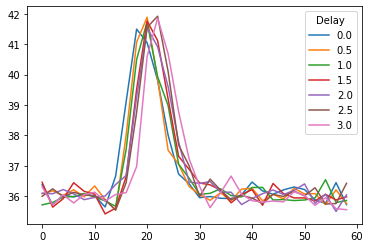

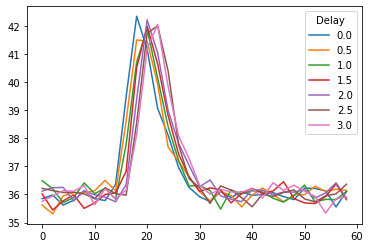

In [11]:
def plot_curve_delay(data_dict, mtt=0):
    data = data_dict['box_curves']
    delay = [0., 0.5, 1., 1.5, 2., 2.5, 3.] # in seconds
    # split on delay time
    curves = np.array_split(data[0], 7, axis=1)

    for ix, curve in enumerate(curves):
        # split on MTT
        subcurves = np.array_split(curve, 7, axis=2)
        # select only with least MTT
        subcurves = subcurves[mtt]
        plt.plot(data_dict['time'], np.mean(subcurves, axis=(1,2)), label=np.round(delay[ix], 2))
    plt.legend(title='Delay')
    plt.show()
for i in range(0,7):
    plot_curve_delay(data_dict, i)

In [17]:
def h_box(time, cbf, t_delay, mtt):
    time = np.array(time)
    h = cbf * 10**-3 * (np.heaviside(time - t_delay, 1)  - np.heaviside(time - t_delay - mtt, 1))
    return h

def h_box_sign(time, cbf, t_delay, mtt):
    time = np.array(time)
    h = cbf  * 10**-3 * 0.5 *(np.sign(time - t_delay)  - np.sign(time - t_delay - mtt))
    return h

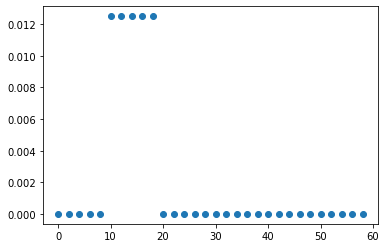

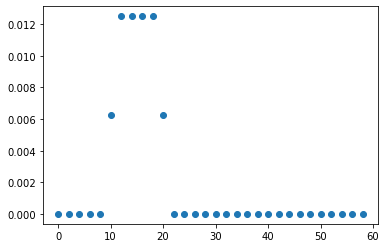

In [35]:
plt.scatter(data_dict['time'],h_box(data_dict['time'], 12.5, 10, 10))
plt.show()
plt.scatter(data_dict['time'],h_box_sign(data_dict['time'], 12.5, 10, 10))
plt.show()

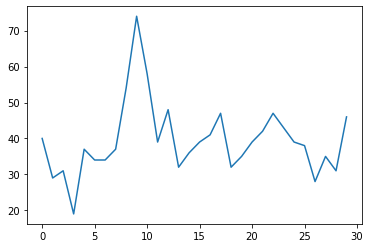

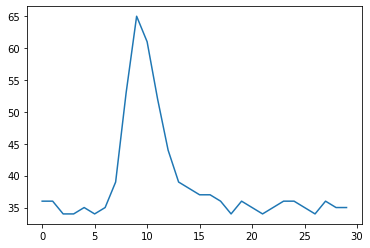

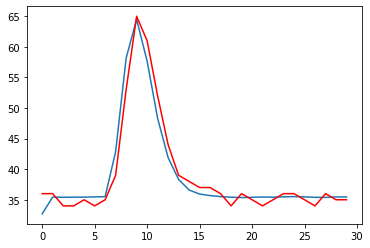

      fun: 3.4202080972461464
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([6.21725284e-07, 0.00000000e+00, 2.13162803e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 5
     njev: 9
   status: 0
  success: True
        x: array([69.30667313,  3.        , 29.8810213 ])

In [38]:
def tracer_model_no_delay(x, cbf, mtt, offset):
    [time, c_aif] = x
    # [cbf, mtt, offset] = parameters

    estimated_c_tissue = np.convolve(c_aif, h_box(time, cbf, 0, mtt))[:len(c_aif)] + offset
    return estimated_c_tissue

def residual(parameters, time, c_aif, c_tissue):
    epsilon = c_tissue - tracer_model_no_delay([time, c_aif], *parameters)
    # square and get mean
    return np.sum(epsilon ** 2) / (len(c_aif))



aif = data_dict['aif']
time = data_dict['time']
tissue = data_dict['box_curves'][4, :, :, :]
# select curves with delay = 0
tissue = np.array_split(tissue, 7, axis=1)[0]
# filter curve
delay_index = 16
mtt_index = -20
plt.plot(tissue[:,delay_index,mtt_index])
plt.show()
tissue = gaussian_filter_spatial(tissue, sd=2.5)
# Select a curve
plt.plot(tissue[:,delay_index,mtt_index])
plt.show()
tissue = tissue[:,delay_index,mtt_index]
# plt.plot(tissue_filtered)
# plt.show()
#
fit = minimize(
                residual,
                np.array([80, 3, 10]),
                args=(time, aif, tissue),
                tol=1e-6,
                method="L-BFGS-B",
            )

#
plt.plot(tracer_model_no_delay([time, aif], *fit.x))
plt.plot(tissue, color='red')
# plt.plot(aif, color = 'k')
plt.show()
fit


In [37]:
from scipy.optimize import curve_fit



# popt, pcov = curve_fit(f,[times, aif],yobs=tissue_filtered,bounds=([0,0,0],[100,40,100]))
popt, pcov = curve_fit(tracer_model_no_delay, [time, aif], ydata=tissue, bounds=([0,0,0],[100,30,100]))
#


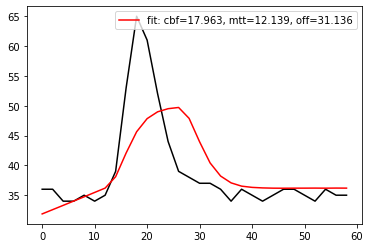

In [33]:
plt.plot(time, tissue, color='k')
plt.plot(time, tracer_model_no_delay([time, aif], *popt), 'r-', label='fit: cbf=%5.3f, mtt=%5.3f, off=%5.3f' % tuple(popt))
plt.legend()

In [61]:
import scipy.optimize as sp
from scipy.integrate import quad
import numpy as np
number = 100

def c_aif_function(t,c_aif):
    print(t)
    return c_aif[int(t)]

def c_aif_intergral(t,c_aif):
    return quad(c_aif_function,0,t,args=(c_aif))[0]

# x_linear = np.linspace(0.001,0.006,number)
# y_linear = 23.33*x_linear + 0.02*(np.random.random(number)-0.5)
# parameter = sp.curve_fit(curvefit,x_linear,y_linear)

def c_tissue_function(times, c_aif, cbf, mtt, offset):
    t_delay = 0
    result = []
    for t in times:
        result.append(cbf * (c_aif_intergral(t-t_delay, c_aif) - c_aif_intergral(t - t_delay - mtt, c_aif)) + offset)
    return result

In [62]:
def residual(parameters, c_aif, c_tissue):
    [cbf, mtt, offset] = parameters
    epsilon = c_tissue - c_tissue_function(times, c_aif, *parameters)
    # square and get mean
    return np.sum(epsilon ** 2) / (len(c_aif))

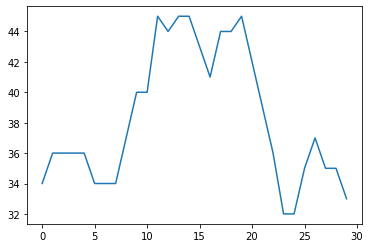

C:\Users\LUCASD~1\AppData\Local\Temp/ipykernel_17660/383009679.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(c_aif_function,0,t,args=(c_aif))[0]


IndexError: index 30 is out of bounds for axis 0 with size 30

In [58]:
times = [i for i in range(0,30,1)]
aif = data_dict['aif']

tissue = data_dict['box_curves'][4, :, :, :]
tissue = np.array_split(tissue, 7, axis=1)
# filter curve
tissue = gaussian_filter_spatial(tissue[0], sd=2.5)

delay_index = 16
mtt_index = -223
# Select a curve
tissue = tissue[:,delay_index,mtt_index]
plt.plot(tissue)
plt.show()
# plt.plot(tissue_filtered)
# plt.show()
#
fit = minimize(
                residual,
                np.array([80, 20, 10]),
                args=(aif, tissue),
                tol=1e-6,
                method="L-BFGS-B",
            )

In [ ]:
# plt.plot(c_tissue_function(times, aif, tissue_filtered, fit.x))
c_tissue_function(times, aif, fit.x[0], fit.x[1], fit.x[2])
# plt.plot(tissue_filtered, color='red')
# # plt.plot(aif, color = 'k')